In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.io import loadmat, savemat
import os
import math
import numpy as np
import pandas as pd
import numpy as np
import librosa

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print(tf.__version__)

2.8.2


In [4]:
# Loading csv file
location = "Audio_Classification-MLSP/"
annot = pd.read_csv(location + "annotations.csv")
mapping = {"Bark": 0, "Meow": 1, "Siren": 2, "Shatter": 3, "Knock": 4, "Crying_and_sobbing": 5, "Microwave_oven": 6, "Vehicle_horn_and_car_horn_and_honking": 7, "Doorbell": 8, "Walk_and_footsteps": 9}

#### Loading Data

##### Creating single Dataset

In [43]:
annot

,Unnamed: 0,fname,label,split
0,0,02639.npy,Bark,train
1,1,1580.npy,Bark,train
2,2,24030.npy,Bark,train
3,3,316499.npy,Bark,train
4,4,413718.npy,Bark,train
...,...,...,...,...
995,995,9956925.npy,Walk_and_footsteps,train
996,996,99611454.npy,Walk_and_footsteps,train
997,997,9979729.npy,Walk_and_footsteps,train
998,998,99818869.npy,Walk_and_footsteps,train


In [ ]:
# Loading data in array
y = np.zeros([1000, 1])
X = np.zeros([1000, 128, 2700])
signal_len = []
for i in range(len(annot)):
  print(i)
  y[i] = mapping[annot.iloc[i, 2]]
  x = np.load(location + "train/" + annot.iloc[i, 1])
  signal_len.append(x.shape[2])
  X[i, :, 0:x.shape[2]] = x[0, :, :]

In [50]:
# Archiving Data for quicker use later
np.savez(location + "Dataset.npz", X = X, y = y, signal_len = signal_len)

##### Preparing Data

In [5]:
# Loading Archived Data
l = np.load(location + "Dataset.npz")
X = l['X']
y = l['y']
signal_len = l['signal_len']

Meow


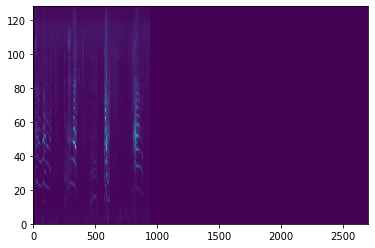

In [6]:
s = 160 # Plotting a mel spectrogram
plt.pcolormesh(X[s])
print(list(mapping.keys())[list(mapping.values()).index(y[s])])

In [7]:
# Splitting into train and validation set
from sklearn.utils import shuffle
X, y, signal_len = shuffle(X, y, np.array(signal_len))
fr = 0.8
X_train = X[:fr*1000, :, :]
y_train = y[:fr*1000]
signal_len_train = signal_len[:fr*1000]
X_val = X[fr*1000:, :, :]
y_val = y[fr*1000:]
signal_len_val = signal_len[fr*1000:]

In [8]:
# For efficient use of RAM
del X
del y

In [9]:
X_test = X_val.copy()
y_test = y_val.copy()
signal_len_test = signal_len_val.copy()

In [10]:
sample_len = 300  #Defining sample length
hop_size = 150

In [11]:
def DuplicatePadding(X, signal_length, sample_length):
  # Duplicate pad samples with signal_length less than sample_length
  for i in range(len(X)):
    dp = signal_length[i]
    while dp<sample_length:
      X[i, :, dp:dp+signal_length[i]] = X[i, :, :signal_length[i]]
      signal_length[i] = sample_length
      dp = dp + signal_length[i]
  return X, signal_length

In [12]:
def SlidingWindow(X, y, signal_length, sample_length, hop_size):
  ## Slice long samples into multiple samples
  data = []
  labels = []
  for i in range(len(y)):
    if signal_length[i] == sample_length:
      data.append(X[i, :, :signal_length[i]])
      labels.append(y[i])
    else:
      p = 0
      while p + sample_length<=signal_length[i]:
        data.append(X[i, :, p:p + sample_length])
        labels.append(y[i])
        p = p + hop_size
      data.append(np.concatenate([X[i, :, p:signal_length[i]], X[i, :, :sample_length - (signal_length[i]-p)]], axis = -1))
      labels.append(y[i])
      
  data = np.array(data)
  labels = np.array(labels)
  return data, labels

In [13]:
X_train, signal_len_train = DuplicatePadding(X_train, signal_len_train, sample_len)
X_val, signal_len_val = DuplicatePadding(X_val, signal_len_val, sample_len)

In [14]:
X_test, signal_len_test = DuplicatePadding(X_test, signal_len_test, sample_len)

In [15]:
X_train, y_train = SlidingWindow(X_train, y_train,signal_len_train, sample_len, hop_size)
X_val, y_val = SlidingWindow(X_val, y_val, signal_len_val, sample_len, hop_size)

In [16]:
X_test_list = []
for x, y in zip(X_test, y_test):
  x, _ = SlidingWindow(np.expand_dims(x, axis = 0), list(y), signal_len_test, sample_len, hop_size)
  del _
  X_test_list.append(x)

In [18]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(2928, 128, 300)
(783, 128, 300)
(2928, 1)
(783, 1)


In [19]:
# np.savez(location + "main.npz", X_train = X_train, X_val = X_val, y_train = y_train, y_val = y_val)

#### ML

In [20]:
# l = np.load(location + "main.npz")
# X_train = l['X_train']
# X_val = l['X_val']
# y_train = l['y_train']
# y_val = l['y_val']
# sample_len = X_train.shape[-1]
# print(X_train.shape)
# print(X_val.shape)
# print(y_train.shape)
# print(y_val.shape)

In [21]:
# One hot encoding
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [22]:
# Shuffling
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state = 42)
X_val, y_val = shuffle(X_val, y_val, random_state = 42)
X_test_list, y_test = shuffle(X_test_list, y_test, random_state = 42)

In [23]:
# Normalizing
# X_train = tf.keras.utils.normalize(X_train)
# X_val = tf.keras.utils.normalize(X_val)
# for x in X_test_list:
#   x = tf.keras.utils.normalize(x)

In [24]:
# Expanding dimention so as to add channel dimension
X_train = np.expand_dims(X_train, axis = 3)
X_val = np.expand_dims(X_val, axis = 3)

In [30]:
inp_shape = (128, sample_len, 1)
ip = tf.keras.Input(shape = inp_shape)

conv1 = layers.Conv2D(32, (5, 5), strides = (1, 1), padding = 'same')(ip)
pool1 = layers.MaxPool2D(pool_size = (2, 2))(conv1)
conv2 = layers.Conv2D(16, (3, 3), strides = (1, 1), padding = 'same')(pool1)
pool2 = layers.MaxPool2D(pool_size = (2, 2))(conv2)
conv3 = layers.Conv2D(8, (3, 3), strides = (1, 1), padding = 'same')(pool2)
pool3 = layers.MaxPool2D(pool_size = (2, 2))(conv3)
flatten = layers.Flatten()(pool3)
dense1 = layers.Dense(32, activation='relu')(flatten)
drop1 = tf.keras.layers.Dropout(.2)(dense1)
dense2 = layers.Dense(32, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(.2)(dense2)
dense3 = layers.Dense(16, activation='relu')(drop2)

out = tf.keras.layers.Dense(num_classes, activation = 'softmax')(dense3)

cnn = tf.keras.Model(inputs = ip, outputs = out)
cnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 300, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 300, 32)      832       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 150, 32)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 150, 16)       4624      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 75, 8)         1160

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
cnn.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['acc'])
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0.01,
    patience=60,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)]
history = cnn.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 1000, batch_size = 100, callbacks = callbacks)

In [35]:
cnn.save('cnn1')

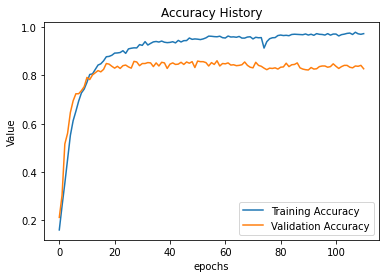

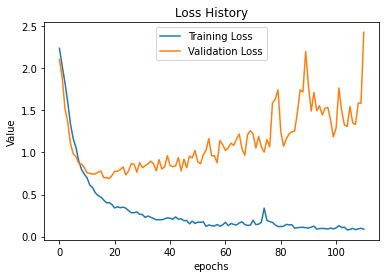

Initial Training accuracy:  0.1601775884628296
Best Training accuracy:  0.9788251519203186
Initial Training loss:  2.235639810562134
Best Training loss:  0.08219312131404877
Initial Validation accuracy:  0.2120051085948944
Best Validation accuracy:  0.860791802406311
Initial Validation loss:  2.104307174682617
Best Validation loss:  0.8769492506980896


In [32]:
#Plotting model history
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.title('Accuracy History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()

#Plotting model history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Loss History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()

print("Initial Training accuracy: ", history.history['acc'][0])
print("Best Training accuracy: ", np.max(history.history['acc']))
print("Initial Training loss: ", history.history['loss'][0])
print("Best Training loss: ", history.history['loss'][np.argmax(history.history['acc'])])
print("Initial Validation accuracy: ", history.history['val_acc'][0])
print("Best Validation accuracy: ", np.max(history.history['val_acc']))
print("Initial Validation loss: ", history.history['val_loss'][0])
print("Best Validation loss: ", history.history['val_loss'][np.argmax(history.history['val_acc'])])

In [33]:
predicted = cnn.predict(X_val)
y_pred = np.argmax(predicted, axis = 1)
y_pred = tf.keras.utils.to_categorical(y_pred, num_classes)
train_acuracy = history.history['acc'][-1]
val_accuracy = accuracy_score(y_val, y_pred)
f1score = f1_score(y_val, y_pred, average = 'weighted')
cm = confusion_matrix(np.argmax(y_val, axis = 1), np.argmax(y_pred, axis = 1))
print(train_acuracy)
print(val_accuracy)
print(f1score)
print(cm)

0.9730191230773926
0.859514687100894
0.856675552465864
[[ 42   7   1   1   0   6   1   3   1   1]
 [  0  40   3   1   1   6   2   7   1   2]
 [  0   0 140   0   0   0   0   1   0   0]
 [  0   3   0  30   2   0   2   5   1   0]
 [  0   0   0   0  40   1   2   0   0   6]
 [  0   2   0   0   0  90   0   2   1   0]
 [  0   0   0   0   2   0  42   0   0   0]
 [  0   0   0   1   0   1   0  66   4   0]
 [  6   2   7   4   0   0   0   0 113   0]
 [  1   0   0   4   4   1   1   0   0  70]]


In [34]:
pred_list = []
for x in X_test_list:
  pred = cnn.predict(x)
  pred_list.append(np.mean(pred, axis = 0))
predicted = np.array(pred_list)
y_pred = np.argmax(predicted, axis = 1)
y_pred = tf.keras.utils.to_categorical(y_pred, num_classes)
train_acuracy = history.history['acc'][-1]
test_accuracy = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred, average = 'weighted')
cm = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis = 1))
print(train_acuracy)
print(test_accuracy)
print(f1score)
print(cm)

0.9730191230773926
0.845
0.84485464958005
[[15  1  1  1  0  2  1  0  0  1]
 [ 0 15  0  0  0  3  0  1  0  1]
 [ 0  0 22  0  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  1  1  1  0]
 [ 0  0  0  0 19  0  2  0  0  4]
 [ 0  0  0  0  0 15  0  0  0  0]
 [ 0  0  0  0  2  0 14  0  0  0]
 [ 0  0  0  0  0  0  0 19  0  0]
 [ 0  0  0  3  0  0  0  0 22  0]
 [ 1  0  0  2  0  1  1  0  0 14]]


In [ ]:
inp_shape = (128, sample_len, 1)
ip = tf.keras.Input(shape = inp_shape)

flatten = layers.Flatten()(ip)
dense1 = layers.Dense(128, activation='relu')(flatten)
drop1 = tf.keras.layers.Dropout(.1)(dense1)
dense2 = layers.Dense(64, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(.1)(dense2)
dense3 = layers.Dense(64, activation='relu')(drop2)
drop3 = tf.keras.layers.Dropout(.1)(dense3)
dense4 = layers.Dense(32, activation='relu')(drop3)

out = tf.keras.layers.Dense(num_classes, activation = 'softmax')(dense4)

denseModel = tf.keras.Model(inputs = ip, outputs = out)
print(denseModel.summary())

opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
denseModel.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['acc'])
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0.01,
    patience=60,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)]
history = denseModel.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 1000, batch_size = 100, callbacks = callbacks)

In [ ]:
inp_shape = (128, sample_len, 1)
ip = tf.keras.Input(shape = inp_shape)

conv1 = layers.Conv2D(16, (6, 2), strides = (1, 1), padding = 'same')(ip)
conv2 = layers.Conv2D(16, (6, 2), strides = (1, 1), padding = 'same')(conv1)
conv3 = layers.Conv2D(24, (5, 1), strides = (1, 1), padding = 'same')(conv2)
conv4 = layers.Conv2D(24, (5, 1), strides = (1, 1), padding = 'same')(conv3)
conv5 = layers.Conv2D(36, (4, 1), strides = (1, 1), padding = 'same')(conv4)
flatten = layers.Flatten()(conv5)
dense1 = layers.Dense(128, activation='relu')(flatten)
drop1 = tf.keras.layers.Dropout(.2)(dense1)
dense2 = layers.Dense(128, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(.2)(dense2)
dense3 = layers.Dense(64, activation='relu')(drop2)

out = tf.keras.layers.Dense(num_classes, activation = 'softmax')(dense3)

cnn2 = tf.keras.Model(inputs = ip, outputs = out)
print(cnn2.summary())

opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
cnn2.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['acc'])
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0.01,
    patience=60,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)]
history = cnn2.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 1000, batch_size = 100, callbacks = callbacks)

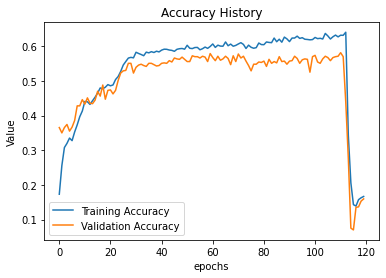

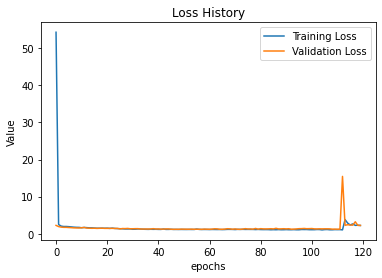

Initial Training accuracy:  0.17315573990345
Best Training accuracy:  0.6400273442268372
Initial Training loss:  54.31969451904297
Best Training loss:  1.0310484170913696
Initial Validation accuracy:  0.36526182293891907
Best Validation accuracy:  0.5810983180999756
Initial Validation loss:  2.2342770099639893
Best Validation loss:  1.207783579826355


In [27]:
#Plotting model history
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.title('Accuracy History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()

#Plotting model history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Loss History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()

print("Initial Training accuracy: ", history.history['acc'][0])
print("Best Training accuracy: ", np.max(history.history['acc']))
print("Initial Training loss: ", history.history['loss'][0])
print("Best Training loss: ", history.history['loss'][np.argmax(history.history['acc'])])
print("Initial Validation accuracy: ", history.history['val_acc'][0])
print("Best Validation accuracy: ", np.max(history.history['val_acc']))
print("Initial Validation loss: ", history.history['val_loss'][0])
print("Best Validation loss: ", history.history['val_loss'][np.argmax(history.history['val_acc'])])